In [1]:
# This code demonstrates how to fine-tune Vision Transformer (ViT) and SWIN models on the CIFAR-10 dataset and apply Grad-CAM visualization.

## 1. Setup Environment
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# !pip install torch torchvision timm pytorch-gradcam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
#!pip show pytorch-gradcam
#!ls /usr/local/lib/python3.11/dist-packages/

In [2]:
## 2. Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

## 3. Data Preparation

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]
    )


c:\Users\user\Miniconda3\envs\rnn_transformer_hw4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
classes_name = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


validation_split = 0.2
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(42) 
np.random.shuffle(indices)


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(
    trainset, 
    batch_size=128, 
    sampler=train_sampler,
    num_workers=2
)

valloader = DataLoader(
    trainset,
    batch_size=128, 
    sampler=val_sampler,
    num_workers=2
)

testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training set size: {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")
print(f"Test set size: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [ ]:
## Improved Model Setup

# Load pre-trained models
vit_model = timm.create_model('vit_base_patch32_224', pretrained=True)
swin_model = timm.create_model('swin_base_patch4_window7_224.ms_in1k', pretrained=True)

# Move models to device first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)
swin_model.to(device)

print("Original ViT head:", vit_model.head)
print("Original SWIN head:", swin_model.head)

with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    
    # ViT 特徵檢查
    vit_features = vit_model.forward_features(dummy_input)
    print(f"ViT features shape: {vit_features.shape}")
    
    # SWIN 特徵檢查
    swin_features = swin_model.forward_features(dummy_input)
    print(f"SWIN features shape: {swin_features.shape}")

print(f"ViT head input features: {vit_model.head.in_features}")
print(f"SWIN head input features: {swin_model.head.fc.in_features}")

vit_model.head = nn.Linear(vit_model.head.in_features, 10)

swin_model.head.fc = nn.Linear(swin_model.head.fc.in_features, 10)

print("\n=== 設置完整模型 Fine-tuning ===")

for param in vit_model.parameters():
    param.requires_grad = True

for param in swin_model.parameters():
    param.requires_grad = True

print(" 所有參數設為可訓練（完整 Fine-tuning）")

def count_parameters(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Frozen parameters: {total_params - trainable_params:,}")
    print(f"  Trainable ratio: {trainable_params/total_params*100:.2f}%")
    return trainable_params

print("\n=== Full Fine-tuning Parameter Statistics ===")
vit_trainable = count_parameters(vit_model, "ViT")
swin_trainable = count_parameters(swin_model, "SWIN")

# Move models back to device after modifications
vit_model.to(device)
swin_model.to(device)

print(f"\n 完整 Fine-tuning 設置完成！")
print(f" ViT 可訓練參數: {vit_trainable:,}")
print(f" Swin 可訓練參數: {swin_trainable:,}")

Original ViT head: Linear(in_features=768, out_features=1000, bias=True)
Original SWIN head: ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=1024, out_features=1000, bias=True)
  (flatten): Identity()
)
ViT features shape: torch.Size([1, 50, 768])
SWIN features shape: torch.Size([1, 7, 7, 1024])
ViT head input features: 768
SWIN head input features: 1024

=== 設置完整模型 Fine-tuning ===
 所有參數設為可訓練（完整 Fine-tuning）

=== Full Fine-tuning Parameter Statistics ===
ViT:
  Total parameters: 87,462,922
  Trainable parameters: 87,462,922
  Frozen parameters: 0
  Trainable ratio: 100.00%
SWIN:
  Total parameters: 86,753,474
  Trainable parameters: 86,753,474
  Frozen parameters: 0
  Trainable ratio: 100.00%

 完整 Fine-tuning 設置完成！
 ViT 可訓練參數: 87,462,922
 Swin 可訓練參數: 86,753,474


In [6]:
def evaluate_model(model, dataloader, criterion=None, return_loss=False):
    
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if labels.dim() > 1:
                labels = labels.squeeze()
            if labels.dim() == 0:
                labels = labels.unsqueeze(0)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if criterion is not None:
                loss = criterion(outputs, labels.long())
                running_loss += loss.item()
    
    accuracy = 100 * correct / total
    
    if return_loss and criterion is not None:
        avg_loss = running_loss / len(dataloader)
        return avg_loss, accuracy
    else:
        return accuracy

In [ ]:
from tqdm import tqdm
def train_model_improved(model, trainloader, valloader, criterion, optimizer, scheduler, 
                        num_epochs=30, model_name="model", patience=7):

    print(f"\n=== 開始訓練 {model_name.upper()} ===")
    
    # 歷史記錄
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'learning_rates': []
    }
    
    best_val_accuracy = 0.0
    patience_counter = 0
    
    # 訓練前評估
    print("訓練前評估...")
    initial_val_acc = evaluate_model(model, valloader)
    print(f"初始驗證準確率: {initial_val_acc:.2f}%")
    
    for epoch in range(num_epochs):
        # === 訓練階段 ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 記錄學習率
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        
        # 進度條
        progress_bar = tqdm(trainloader, 
                           desc=f'{model_name.upper()} Epoch {epoch+1}/{num_epochs}',
                           leave=False)
        
        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 確保標籤格式正確
            if labels.dim() > 1:
                labels = labels.squeeze()
            if labels.dim() == 0:
                labels = labels.unsqueeze(0)
            
            # 前向傳播
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            
            # 反向傳播
            loss.backward()
            
            # 梯度裁剪（防止梯度爆炸）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # 統計
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 更新進度條
            if batch_idx % 10 == 0:  # 每10個batch更新一次
                current_acc = 100 * correct / total
                progress_bar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{current_acc:.2f}%',
                    'LR': f'{current_lr:.6f}'
                })
        
        # === 計算訓練指標 ===
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        
        # === 驗證階段 ===
        val_loss, val_accuracy = evaluate_model(model, valloader, criterion, return_loss=True)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # === 打印結果 ===
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
        print(f'  Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        
        # === 保存最佳模型 ===
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_val_accuracy': best_val_accuracy,
                'history': history
            }, f'{model_name}_best.pth')
            print(f'  保存最佳模型! 驗證準確率: {val_accuracy:.2f}% (提升 {val_accuracy-best_val_accuracy:.2f}%)')
        else:
            patience_counter += 1
            print(f'  無改善. 耐心計數: {patience_counter}/{patience}')
            
            if patience_counter >= patience:
                print(f"  Early stopping 觸發 (連續 {patience} epochs 無改善)")
                break
        
        # === 更新學習率 ===
        if scheduler is not None:
            scheduler.step()
        
        print("-" * 50)
    
    if best_val_accuracy > 0:
        print(f"\n 載入最佳模型 (驗證準確率: {best_val_accuracy:.2f}%)")
        checkpoint = torch.load(f'{model_name}_best.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f" {model_name.upper()} 訓練完成!")
    print(f"   最佳驗證準確率: {best_val_accuracy:.2f}%")
    print(f"   改善幅度: {best_val_accuracy - initial_val_acc:.2f}%")
    
    return model, history

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR


print("=== Fine-tuning 設置 ===")

def count_trainable_parameters(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}:")
    print(f"  總參數: {total_params:,}")
    print(f"  可訓練參數: {trainable_params:,}")
    print(f"  可訓練比例: {trainable_params/total_params*100:.2f}%")
    return trainable_params

vit_trainable = count_trainable_parameters(vit_model, "ViT")
swin_trainable = count_trainable_parameters(swin_model, "Swin")

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
print(" 使用 CrossEntropyLoss with label smoothing")

vit_lr = 5e-4 if vit_trainable > 10_000_000 else 1e-3
swin_lr = 5e-4 if swin_trainable > 10_000_000 else 1e-3

vit_optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, vit_model.parameters()), 
    lr=vit_lr, 
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

swin_optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, swin_model.parameters()), 
    lr=swin_lr,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

print(f"ViT 學習率: {vit_lr}")
print(f"Swin 學習率: {swin_lr}")

vit_scheduler = CosineAnnealingLR(vit_optimizer, T_max=30, eta_min=1e-6)
swin_scheduler = CosineAnnealingLR(swin_optimizer, T_max=30, eta_min=1e-6)

=== Fine-tuning 設置 ===
ViT:
  總參數: 87,462,922
  可訓練參數: 87,462,922
  可訓練比例: 100.00%
Swin:
  總參數: 86,753,474
  可訓練參數: 86,753,474
  可訓練比例: 100.00%
 使用 CrossEntropyLoss with label smoothing
ViT 學習率: 0.0005
Swin 學習率: 0.0005


In [9]:
def plot_training_history(vit_history, swin_history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(vit_history['train_loss'], label='ViT Train', color='blue')
    axes[0, 0].plot(vit_history['val_loss'], label='ViT Val', color='lightblue')
    axes[0, 0].plot(swin_history['train_loss'], label='Swin Train', color='red')
    axes[0, 0].plot(swin_history['val_loss'], label='Swin Val', color='lightcoral')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(vit_history['train_accuracy'], label='ViT Train', color='blue')
    axes[0, 1].plot(vit_history['val_accuracy'], label='ViT Val', color='lightblue')
    axes[0, 1].plot(swin_history['train_accuracy'], label='Swin Train', color='red')
    axes[0, 1].plot(swin_history['val_accuracy'], label='Swin Val', color='lightcoral')
    axes[0, 1].set_title('Training & Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(vit_history['learning_rates'], label='ViT LR', color='blue')
    axes[1, 0].plot(swin_history['learning_rates'], label='Swin LR', color='red')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(vit_history['val_accuracy'], label='ViT', color='blue', linewidth=2)
    axes[1, 1].plot(swin_history['val_accuracy'], label='Swin', color='red', linewidth=2)
    axes[1, 1].set_title('Validation Accuracy Comparison')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
vit_model.to(device)
swin_model.to(device)

print(" 開始 Fine-tuning...")
print(f" 訓練集大小: {len(trainloader)} batches")
print(f" 驗證集大小: {len(valloader)} batches")
print(f" 設備: {device}")

 開始 Fine-tuning...
 訓練集大小: 313 batches
 驗證集大小: 79 batches
 設備: cuda


In [11]:
# 訓練 ViT
print("\n" + "="*60)
vit_model, vit_history = train_model_improved(
    vit_model, trainloader, valloader, criterion, 
    vit_optimizer, vit_scheduler, 
    num_epochs=30, model_name="vit", patience=7
)



=== 開始訓練 VIT ===
訓練前評估...
初始驗證準確率: 7.03%



Epoch 1/30:
  Train - Loss: 1.0253, Accuracy: 76.99%
  Val   - Loss: 0.8180, Accuracy: 86.29%
  Learning Rate: 0.000500
  保存最佳模型! 驗證準確率: 86.29% (提升 0.00%)
--------------------------------------------------



Epoch 2/30:
  Train - Loss: 0.7372, Accuracy: 89.84%
  Val   - Loss: 0.7719, Accuracy: 88.01%
  Learning Rate: 0.000499
  保存最佳模型! 驗證準確率: 88.01% (提升 0.00%)
--------------------------------------------------



Epoch 3/30:
  Train - Loss: 0.6796, Accuracy: 92.39%
  Val   - Loss: 0.7505, Accuracy: 89.27%
  Learning Rate: 0.000495
  保存最佳模型! 驗證準確率: 89.27% (提升 0.00%)
--------------------------------------------------



Epoch 4/30:
  Train - Loss: 0.6487, Accuracy: 93.66%
  Val   - Loss: 0.7668, Accuracy: 88.82%
  Learning Rate: 0.000488
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 5/30:
  Train - Loss: 0.6192, Accuracy: 94.88%
  Val   - Loss: 0.7590, Accuracy: 88.99%
  Learning Rate: 0.000478
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 6/30:
  Train - Loss: 0.5986, Accuracy: 95.78%
  Val   - Loss: 0.8022, Accuracy: 87.95%
  Learning Rate: 0.000467
  無改善. 耐心計數: 3/7
--------------------------------------------------



Epoch 7/30:
  Train - Loss: 0.5810, Accuracy: 96.61%
  Val   - Loss: 0.7497, Accuracy: 89.87%
  Learning Rate: 0.000452
  保存最佳模型! 驗證準確率: 89.87% (提升 0.00%)
--------------------------------------------------



Epoch 8/30:
  Train - Loss: 0.5686, Accuracy: 97.11%
  Val   - Loss: 0.8111, Accuracy: 88.03%
  Learning Rate: 0.000436
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 9/30:
  Train - Loss: 0.5550, Accuracy: 97.72%
  Val   - Loss: 0.7664, Accuracy: 89.10%
  Learning Rate: 0.000417
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 10/30:
  Train - Loss: 0.5461, Accuracy: 98.12%
  Val   - Loss: 0.7606, Accuracy: 89.77%
  Learning Rate: 0.000397
  無改善. 耐心計數: 3/7
--------------------------------------------------



Epoch 11/30:
  Train - Loss: 0.5395, Accuracy: 98.35%
  Val   - Loss: 0.7784, Accuracy: 89.46%
  Learning Rate: 0.000375
  無改善. 耐心計數: 4/7
--------------------------------------------------



Epoch 12/30:
  Train - Loss: 0.5306, Accuracy: 98.75%
  Val   - Loss: 0.7708, Accuracy: 89.98%
  Learning Rate: 0.000352
  保存最佳模型! 驗證準確率: 89.98% (提升 0.00%)
--------------------------------------------------



Epoch 13/30:
  Train - Loss: 0.5236, Accuracy: 99.08%
  Val   - Loss: 0.7645, Accuracy: 89.87%
  Learning Rate: 0.000328
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 14/30:
  Train - Loss: 0.5228, Accuracy: 99.08%
  Val   - Loss: 0.7499, Accuracy: 90.39%
  Learning Rate: 0.000302
  保存最佳模型! 驗證準確率: 90.39% (提升 0.00%)
--------------------------------------------------



Epoch 15/30:
  Train - Loss: 0.5145, Accuracy: 99.42%
  Val   - Loss: 0.7566, Accuracy: 90.51%
  Learning Rate: 0.000277
  保存最佳模型! 驗證準確率: 90.51% (提升 0.00%)
--------------------------------------------------



Epoch 16/30:
  Train - Loss: 0.5119, Accuracy: 99.53%
  Val   - Loss: 0.7319, Accuracy: 91.34%
  Learning Rate: 0.000251
  保存最佳模型! 驗證準確率: 91.34% (提升 0.00%)
--------------------------------------------------



Epoch 17/30:
  Train - Loss: 0.5068, Accuracy: 99.72%
  Val   - Loss: 0.7441, Accuracy: 91.27%
  Learning Rate: 0.000224
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 18/30:
  Train - Loss: 0.5076, Accuracy: 99.71%
  Val   - Loss: 0.7425, Accuracy: 91.40%
  Learning Rate: 0.000199
  保存最佳模型! 驗證準確率: 91.40% (提升 0.00%)
--------------------------------------------------



Epoch 19/30:
  Train - Loss: 0.5055, Accuracy: 99.80%
  Val   - Loss: 0.7411, Accuracy: 91.38%
  Learning Rate: 0.000173
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 20/30:
  Train - Loss: 0.5026, Accuracy: 99.90%
  Val   - Loss: 0.7159, Accuracy: 92.47%
  Learning Rate: 0.000149
  保存最佳模型! 驗證準確率: 92.47% (提升 0.00%)
--------------------------------------------------



Epoch 21/30:
  Train - Loss: 0.5012, Accuracy: 99.97%
  Val   - Loss: 0.7196, Accuracy: 92.43%
  Learning Rate: 0.000126
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 22/30:
  Train - Loss: 0.5005, Accuracy: 100.00%
  Val   - Loss: 0.7147, Accuracy: 92.45%
  Learning Rate: 0.000104
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 23/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7090, Accuracy: 92.58%
  Learning Rate: 0.000084
  保存最佳模型! 驗證準確率: 92.58% (提升 0.00%)
--------------------------------------------------



Epoch 24/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7097, Accuracy: 92.63%
  Learning Rate: 0.000065
  保存最佳模型! 驗證準確率: 92.63% (提升 0.00%)
--------------------------------------------------



Epoch 25/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7128, Accuracy: 92.65%
  Learning Rate: 0.000049
  保存最佳模型! 驗證準確率: 92.65% (提升 0.00%)
--------------------------------------------------



Epoch 26/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7111, Accuracy: 92.67%
  Learning Rate: 0.000034
  保存最佳模型! 驗證準確率: 92.67% (提升 0.00%)
--------------------------------------------------



Epoch 27/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7077, Accuracy: 92.69%
  Learning Rate: 0.000023
  保存最佳模型! 驗證準確率: 92.69% (提升 0.00%)
--------------------------------------------------



Epoch 28/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7114, Accuracy: 92.68%
  Learning Rate: 0.000013
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 29/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7095, Accuracy: 92.69%
  Learning Rate: 0.000006
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 30/30:
  Train - Loss: 0.5004, Accuracy: 100.00%
  Val   - Loss: 0.7085, Accuracy: 92.68%
  Learning Rate: 0.000002
  無改善. 耐心計數: 3/7
--------------------------------------------------

 載入最佳模型 (驗證準確率: 92.69%)


C:\Users\user\AppData\Local\Temp\ipykernel_20972\845575988.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{model_name}_best.pth')


 VIT 訓練完成!
   最佳驗證準確率: 92.69%
   改善幅度: 85.66%


In [9]:
print("\n" + "="*60)
swin_model, swin_history = train_model_improved(
    swin_model, trainloader, valloader, criterion,
    swin_optimizer, swin_scheduler, 
    num_epochs=15, model_name="swin", patience=7
)



=== 開始訓練 SWIN ===
訓練前評估...
初始驗證準確率: 10.99%



Epoch 1/15:
  Train - Loss: 0.7879, Accuracy: 88.11%
  Val   - Loss: 0.7618, Accuracy: 88.59%
  Learning Rate: 0.000500
  保存最佳模型! 驗證準確率: 88.59% (提升 0.00%)
--------------------------------------------------



Epoch 2/15:
  Train - Loss: 0.6719, Accuracy: 92.96%
  Val   - Loss: 0.7181, Accuracy: 90.81%
  Learning Rate: 0.000499
  保存最佳模型! 驗證準確率: 90.81% (提升 0.00%)
--------------------------------------------------



Epoch 3/15:
  Train - Loss: 0.6320, Accuracy: 94.52%
  Val   - Loss: 0.7176, Accuracy: 91.30%
  Learning Rate: 0.000495
  保存最佳模型! 驗證準確率: 91.30% (提升 0.00%)
--------------------------------------------------



Epoch 4/15:
  Train - Loss: 0.6044, Accuracy: 95.76%
  Val   - Loss: 0.7166, Accuracy: 91.47%
  Learning Rate: 0.000488
  保存最佳模型! 驗證準確率: 91.47% (提升 0.00%)
--------------------------------------------------



Epoch 5/15:
  Train - Loss: 0.5927, Accuracy: 96.27%
  Val   - Loss: 0.6734, Accuracy: 92.99%
  Learning Rate: 0.000478
  保存最佳模型! 驗證準確率: 92.99% (提升 0.00%)
--------------------------------------------------



Epoch 6/15:
  Train - Loss: 0.5768, Accuracy: 96.90%
  Val   - Loss: 0.7014, Accuracy: 91.91%
  Learning Rate: 0.000467
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 7/15:
  Train - Loss: 0.5630, Accuracy: 97.54%
  Val   - Loss: 0.6543, Accuracy: 93.81%
  Learning Rate: 0.000452
  保存最佳模型! 驗證準確率: 93.81% (提升 0.00%)
--------------------------------------------------



Epoch 8/15:
  Train - Loss: 0.5530, Accuracy: 97.86%
  Val   - Loss: 0.6494, Accuracy: 93.93%
  Learning Rate: 0.000436
  保存最佳模型! 驗證準確率: 93.93% (提升 0.00%)
--------------------------------------------------



Epoch 9/15:
  Train - Loss: 0.5476, Accuracy: 98.14%
  Val   - Loss: 0.6651, Accuracy: 93.64%
  Learning Rate: 0.000417
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 10/15:
  Train - Loss: 0.5388, Accuracy: 98.46%
  Val   - Loss: 0.6692, Accuracy: 93.21%
  Learning Rate: 0.000397
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 11/15:
  Train - Loss: 0.5325, Accuracy: 98.70%
  Val   - Loss: 0.6490, Accuracy: 94.22%
  Learning Rate: 0.000375
  保存最佳模型! 驗證準確率: 94.22% (提升 0.00%)
--------------------------------------------------



Epoch 12/15:
  Train - Loss: 0.5230, Accuracy: 99.09%
  Val   - Loss: 0.6397, Accuracy: 94.52%
  Learning Rate: 0.000352
  保存最佳模型! 驗證準確率: 94.52% (提升 0.00%)
--------------------------------------------------



Epoch 13/15:
  Train - Loss: 0.5213, Accuracy: 99.16%
  Val   - Loss: 0.6478, Accuracy: 94.30%
  Learning Rate: 0.000328
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 14/15:
  Train - Loss: 0.5186, Accuracy: 99.28%
  Val   - Loss: 0.6518, Accuracy: 94.30%
  Learning Rate: 0.000302
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 15/15:
  Train - Loss: 0.5116, Accuracy: 99.57%
  Val   - Loss: 0.6595, Accuracy: 94.04%
  Learning Rate: 0.000277
  無改善. 耐心計數: 3/7
--------------------------------------------------

 載入最佳模型 (驗證準確率: 94.52%)


C:\Users\user\AppData\Local\Temp\ipykernel_20900\845575988.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{model_name}_best.pth')


 SWIN 訓練完成!
   最佳驗證準確率: 94.52%
   改善幅度: 83.53%


In [ ]:
print("\n" + "="*60)
print(" 最終測試集評估...")

vit_test_accuracy = evaluate_model(vit_model, testloader)
swin_test_accuracy = evaluate_model(swin_model, testloader)

print(f"   ViT 測試準確率:  {vit_test_accuracy:.2f}%")
print(f"   Swin 測試準確率: {swin_test_accuracy:.2f}%")


 最終測試集評估...
   ViT 測試準確率:  95.33%
   Swin 測試準確率: 97.40%


In [ ]:
import timm
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_model = timm.create_model('vit_base_patch32_224', pretrained=False)
vit_model.head = nn.Linear(vit_model.head.in_features, 10)
vit_model.load_state_dict(torch.load('./test_4/vit_best.pth', map_location=device)['model_state_dict'])
vit_model.to(device).eval()

swin_model = timm.create_model('swin_base_patch4_window7_224.ms_in1k', pretrained=False)
swin_model.head.fc = nn.Linear(swin_model.head.fc.in_features, 10)
swin_model.load_state_dict(torch.load('./test_4/swin_best.pth', map_location=device)['model_state_dict'])
swin_model.to(device).eval()

C:\Users\user\AppData\Local\Temp\ipykernel_20900\3336883151.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load('./test_4/vit_best.pth'

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [13]:
import timm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)

dataiter = iter(testloader)
images, labels = next(dataiter)
image_batch = [images[i] for i in range(10)]
label_batch = [labels[i].item() for i in range(10)]


Files already downloaded and verified


In [14]:
from scipy.ndimage import zoom

class GradCAM:
    def __init__(self, model, target_layers, reshape_transform=None):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.activations = []
        self.gradients = []
        self.handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations.append(output[0] if isinstance(output, tuple) else output)

        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0] if isinstance(grad_output, tuple) else grad_output)

        for layer in self.target_layers:
            self.handles.append(layer.register_forward_hook(forward_hook))
            self.handles.append(layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def __call__(self, input_tensor, target_category=None):
        self.activations, self.gradients = [], []
        input_tensor.requires_grad_(True)
        output = self.model(input_tensor)
        if target_category is None:
            target_category = torch.argmax(output, dim=1)
        self.model.zero_grad()
        target = output[0, target_category[0]]
        target.backward(retain_graph=True)
        activations = self.reshape_transform(self.activations[-1])
        gradients = self.reshape_transform(self.gradients[-1])
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * activations).sum(dim=1)).squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam
def reshape_transform_vit(tensor):
    tensor = tensor[:, 1:, :]
    B, N, C = tensor.shape
    H = W = int(N ** 0.5)
    tensor = tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    return tensor

def reshape_transform_swin(tensor):
    if tensor.dim() == 3:
        B, N, C = tensor.shape
        H = W = int(N ** 0.5)
        tensor = tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    elif tensor.dim() == 4:
        tensor = tensor.permute(0, 3, 1, 2)
    return tensor

def show_cam_on_image(img_tensor, cam_mask):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    cam_mask = zoom(cam_mask, (img.shape[0] / cam_mask.shape[0], img.shape[1] / cam_mask.shape[1]))
    heatmap = plt.cm.jet(cam_mask)[:, :, :3]
    return np.clip(heatmap * 0.5 + img * 0.5, 0, 1)



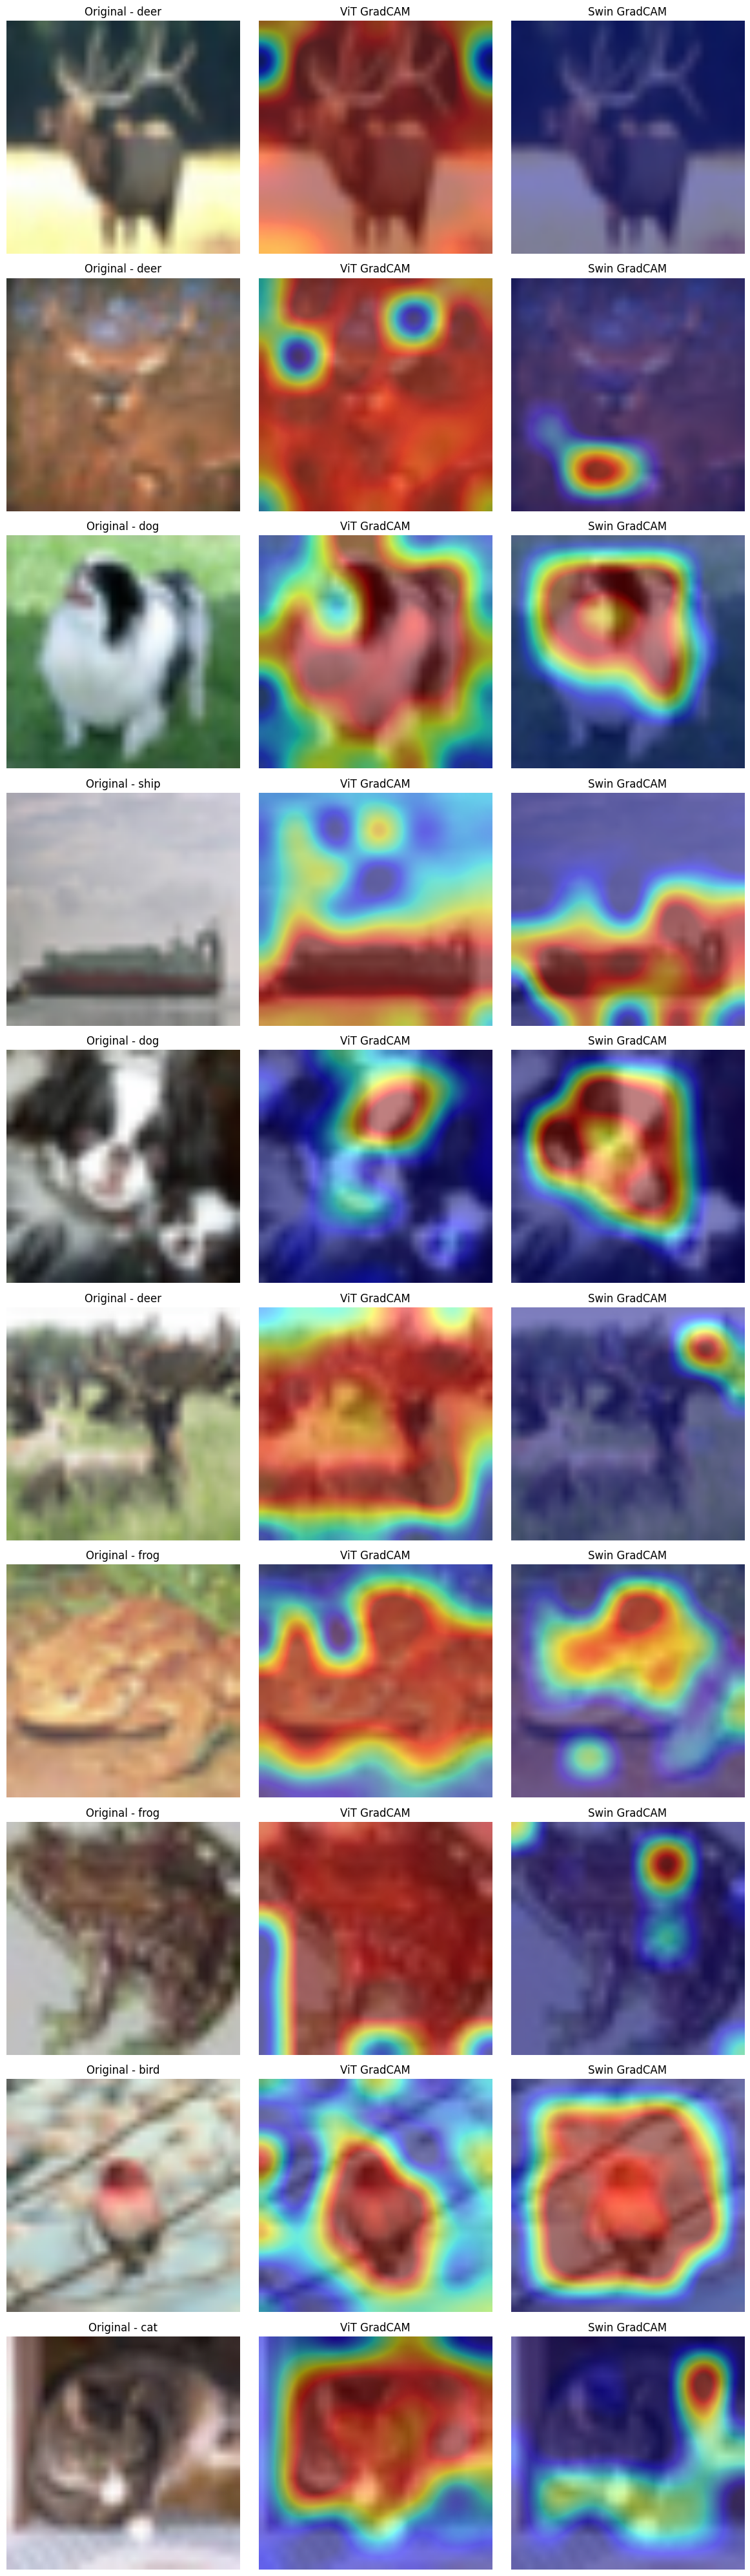

In [15]:
import matplotlib.pyplot as plt
import numpy as np
classes_name = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

fig, axes = plt.subplots(len(image_batch), 3, figsize=(12, 4 * len(image_batch)))
for i, img in enumerate(image_batch):
    img_input = img.unsqueeze(0).to(device)
    # ViT GradCAM
    vit_cam = GradCAM(vit_model, [vit_model.blocks[-1].norm1], reshape_transform_vit)
    vit_result = vit_cam(img_input)
    vit_cam.remove_hooks()
    # Swin GradCAM
    swin_cam = GradCAM(swin_model, [swin_model.layers[-1].blocks[-1].attn], reshape_transform_swin)
    swin_result = swin_cam(img_input)
    swin_cam.remove_hooks()
    # Plotting

    # let original image not blue
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    axes[i][0].imshow(img_np)

    axes[i][0].set_title(f"Original - {classes_name[label_batch[i]]}")
    axes[i][1].imshow(show_cam_on_image(img, vit_result))
    axes[i][1].set_title(f"ViT GradCAM")
    axes[i][2].imshow(show_cam_on_image(img, swin_result))
    axes[i][2].set_title(f"Swin GradCAM")
    for j in range(3):
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()
